In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import keras
import os
import sys

from PIL import Image
from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import audioFeatureExtraction

sys.path.append('..')
import data
import model
import preprocessing
import utils

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.
C:\Users\PC\Anaconda3\envs\TensorFlow-GPU-Keras\lib\site-packages\pydub\utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
params = utils.yaml_to_dict(os.path.join('..','config.yml'))
params['data_dir'] = os.path.join('..',params['data_dir'])
params['model_dir'] = os.path.join('..',params['model_dir'])

## Construir el nuevo conjunto de datos

Este dataset contiene el Espectograma de la palabra completa, osea que no se le aplica el proceso de separación por ventanas

In [3]:
def save_img(spectogram,specgram_folder,file):
    
    if not os.path.exists(specgram_folder):
        os.makedirs(specgram_folder)
      
    fpath = os.path.join(specgram_folder, file)
    im = Image.fromarray(spectogram,'L')
    im.save(fpath)

def generate_spectogram_images(params):
    
    shape_list = list()
    
    audios_path = os.path.join(params['data_dir'],params['data_dir_audios'])
    
    for root, dirs, files in os.walk(audios_path, topdown=False):
        for name in files:
            
            specgram_folder = os.path.join(params['data_dir'],params['data_dir_images']+'_test',root.split(os.path.sep)[-1])
        
            [fs, x] = audioBasicIO.readAudioFile(os.path.join(root, name))
            x = audioBasicIO.stereo2mono(x)
            x = preprocessing._rescaled_signal(x)
            
            segments = preprocessing._find_segments_from_audio(x=x, fs=fs)
            
            for i,segment in enumerate(segments):
                
                imname = 'specgram_matrix_' + os.path.splitext(name)[0] + '_segment' + str(i) + '.png'
                audio_fragment = preprocessing._extract_audio_fragments(x=x, fs=fs, segment=segment)

                specgram, TimeAxis, FreqAxis = audioFeatureExtraction.stSpectogram(
                    audio_fragment,
                    fs,
                    round(fs * 0.02),
                    round(fs * 0.01),
                    False)
                
                shape_list.append(specgram.shape)
            
                save_img(specgram,specgram_folder,imname)
                
    return shape_list

In [4]:
s_list = generate_spectogram_images(params)
width, height = np.mean(s_list, axis=0)
width = int(width)
height = int(height)

In [4]:
width = 110
height = 480

In [5]:
params['data_dir_images'] = 'images_test'
preprocessing.split_data(params)

## Instanciar el modelo

In [6]:
inputs = tf.keras.layers.Input(shape=(width, height, 3))
net = model.ModelArchitecture(num_classes=params['num_classes'])
x = net(inputs, training=False)
net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 240, 64)       9472      
_________________________________________________________________
batch_normalization (BatchNo (None, 55, 240, 64)       256       
_________________________________________________________________
activation (Activation)      (None, 55, 240, 64)       0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                650       
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
Total params: 10,378
Trainable params: 10,250
Non-trainable params: 128
_________________________________________________________________


## Crear el generador

In [7]:
import pandas as pd
def make_datagenerator(params, mode, image_shape):
    
    file_path = mode + '.txt'
    data_path = os.path.join(params['data_dir'],file_path)
    
    df = pd.read_csv(data_path, sep="\t", header=0)
    datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    generator = datagen.flow_from_dataframe(
        dataframe = df,
        x_col = 'images',
        y_col = 'labels',
        target_size = image_shape,
        batch_size = params['batch_size'],
        class_mode = params['class_mode']
    )
   
    return generator

In [8]:
print('Data in training')
train_generator = make_datagenerator(params,mode='training',image_shape=(width, height))
print('Data in validation')
val_generator = make_datagenerator(params,mode='validation',image_shape=(width, height))

Data in training
Found 2439 images.
Data in validation
Found 487 images.


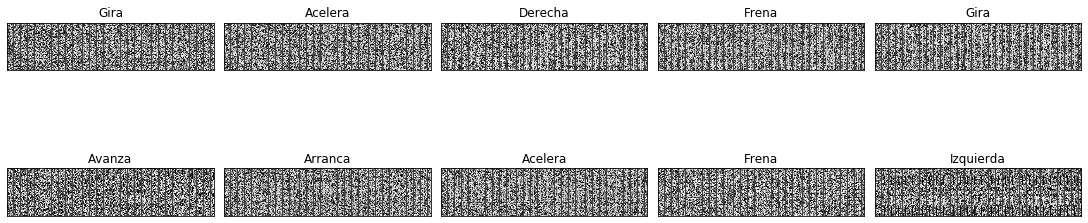

In [9]:
label_id_map = preprocessing._load_label_id_map(params)
label_map = {v:k for (k, v) in label_id_map.items()}

fig, axis = plt.subplots(2,5, figsize=(15,4), constrained_layout=True)
iteration = next(train_generator)
size = len(iteration[0])
k = 0
for i in range(2):
    for j in range(size//2):
        
        spectogram = iteration[0][k]
        label = label_map[iteration[1][k]]
        
        axis[i][j].imshow(spectogram)
        axis[i][j].title.set_text(label)

        axis[i][j].get_xaxis().set_visible(False)
        axis[i][j].get_yaxis().set_visible(False)
        
        k += 1
plt.show()

## Probar el modelo

In [10]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(params['model_dir'], 'tf_ckpt'), 
    save_weights_only=True, 
    verbose=1,
    period=5)

tb_callback = tf.keras.callbacks.TensorBoard(
    os.path.join(params['model_dir'], 'logs'))

optimizer = tf.keras.optimizers.Adam(lr=0.001)

steps_per_epoch = train_generator.n // params['batch_size']
validation_steps = val_generator.n // params['batch_size']

net.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
net.fit_generator(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=params['num_epochs'],
    workers=4,
    validation_data=val_generator, 
    validation_steps=validation_steps,
    callbacks=[cp_callback, tb_callback])

Epoch 1/700
243/243 [==============================] - 18s 74ms/step - loss: 2.3085 - sparse_categorical_accuracy: 0.1042 - val_loss: 2.3009 - val_sparse_categorical_accuracy: 0.1167
Epoch 2/700
243/243 [==============================] - 15s 61ms/step - loss: 2.3012 - sparse_categorical_accuracy: 0.1149 - val_loss: 2.2998 - val_sparse_categorical_accuracy: 0.1167
Epoch 3/700
243/243 [==============================] - 17s 68ms/step - loss: 2.3015 - sparse_categorical_accuracy: 0.1136 - val_loss: 2.2992 - val_sparse_categorical_accuracy: 0.1167
Epoch 4/700
243/243 [==============================] - 17s 71ms/step - loss: 2.3001 - sparse_categorical_accuracy: 0.1153 - val_loss: 2.2988 - val_sparse_categorical_accuracy: 0.1167
Epoch 5/700
241/243 [============================>.] - ETA: 0s - loss: 2.2997 - sparse_categorical_accuracy: 0.1145
Epoch 00005: saving model to ..\checkpoints\tf_ckpt

Consider using a TensorFlow optimizer from `tf.train`.
243/243 [==============================] - 1

243/243 [==============================] - 16s 67ms/step - loss: 2.2991 - sparse_categorical_accuracy: 0.1136 - val_loss: 2.2968 - val_sparse_categorical_accuracy: 0.1167
Epoch 16/700
243/243 [==============================] - 15s 62ms/step - loss: 2.2973 - sparse_categorical_accuracy: 0.1177 - val_loss: 2.2941 - val_sparse_categorical_accuracy: 0.1167
Epoch 17/700
243/243 [==============================] - 17s 68ms/step - loss: 2.2950 - sparse_categorical_accuracy: 0.1148 - val_loss: 2.2902 - val_sparse_categorical_accuracy: 0.1167
Epoch 18/700
243/243 [==============================] - 15s 60ms/step - loss: 2.2928 - sparse_categorical_accuracy: 0.1116 - val_loss: 2.2897 - val_sparse_categorical_accuracy: 0.1167
Epoch 19/700
243/243 [==============================] - 15s 62ms/step - loss: 2.2902 - sparse_categorical_accuracy: 0.1214 - val_loss: 2.2865 - val_sparse_categorical_accuracy: 0.1125
Epoch 20/700
242/243 [============================>.] - ETA: 0s - loss: 2.2873 - sparse_categ

243/243 [==============================] - 16s 64ms/step - loss: 2.2490 - sparse_categorical_accuracy: 0.1445 - val_loss: 2.2422 - val_sparse_categorical_accuracy: 0.1188
Epoch 38/700
243/243 [==============================] - 16s 64ms/step - loss: 2.2554 - sparse_categorical_accuracy: 0.1099 - val_loss: 2.2416 - val_sparse_categorical_accuracy: 0.1292
Epoch 39/700
243/243 [==============================] - 15s 61ms/step - loss: 2.2516 - sparse_categorical_accuracy: 0.1214 - val_loss: 2.2427 - val_sparse_categorical_accuracy: 0.1292
Epoch 40/700
242/243 [============================>.] - ETA: 0s - loss: 2.2465 - sparse_categorical_accuracy: 0.1215  ETA: 12s - loss: 2.2441 - sparse_categorical_ - ETA: 11s - loss: 2.2429 - sparse_cate - ETA: 10s - loss: 2.2448 - sparse_categorical - ETA: 9s - loss: 2.2446 - sparse_ca - ETA: 7s - loss: 2.2 - ETA: 4s - loss: 2.2439 - sparse_cat - ETA: 3s - loss: 2.2457 - sparse_categorical_accuracy:  - ETA: 2s - loss: 2.2463 
Epoch 00040: saving model to .

Epoch 61/700
243/243 [==============================] - 15s 61ms/step - loss: 2.2454 - sparse_categorical_accuracy: 0.1198 - val_loss: 2.2334 - val_sparse_categorical_accuracy: 0.1271s - loss: 2.2479 - ETA: 3s - loss: 2.2473 - sparse_categor - ETA: 1s - loss: 2.2481 - sparse_
Epoch 62/700
243/243 [==============================] - 16s 67ms/step - loss: 2.2431 - sparse_categorical_accuracy: 0.1334 - val_loss: 2.2342 - val_sparse_categorical_accuracy: 0.1271
Epoch 63/700
243/243 [==============================] - 15s 62ms/step - loss: 2.2429 - sparse_categorical_accuracy: 0.1240 - val_loss: 2.2318 - val_sparse_categorical_accuracy: 0.1292
Epoch 64/700
243/243 [==============================] - 15s 62ms/step - loss: 2.2434 - sparse_categorical_accuracy: 0.1293 - val_loss: 2.2327 - val_sparse_categorical_accuracy: 0.1292
Epoch 65/700
242/243 [============================>.] - ETA: 0s - loss: 2.2451 - sparse_categorical_accuracy: 0.1228- ETA: 4s - loss: 2.2470 - spa - ETA: 2s - loss: 2.2447

Epoch 83/700
243/243 [==============================] - 16s 66ms/step - loss: 2.2352 - sparse_categorical_accuracy: 0.1215 - val_loss: 2.2279 - val_sparse_categorical_accuracy: 0.1333
Epoch 84/700
243/243 [==============================] - 16s 66ms/step - loss: 2.2431 - sparse_categorical_accuracy: 0.1334 - val_loss: 2.2280 - val_sparse_categorical_accuracy: 0.1583
Epoch 85/700
242/243 [============================>.] - ETA: 0s - loss: 2.2343 - sparse_categorical_accuracy: 0.1240
Epoch 00085: saving model to ..\checkpoints\tf_ckpt

Consider using a TensorFlow optimizer from `tf.train`.
243/243 [==============================] - 14s 59ms/step - loss: 2.2343 - sparse_categorical_accuracy: 0.1235 - val_loss: 2.2290 - val_sparse_categorical_accuracy: 0.1313
Epoch 86/700
243/243 [==============================] - 16s 67ms/step - loss: 2.2381 - sparse_categorical_accuracy: 0.1305 - val_loss: 2.2262 - val_sparse_categorical_accuracy: 0.1333
Epoch 87/700
243/243 [==============================

243/243 [==============================] - 21s 88ms/step - loss: 2.2254 - sparse_categorical_accuracy: 0.1688 - val_loss: 2.2164 - val_sparse_categorical_accuracy: 0.1750
Epoch 106/700
243/243 [==============================] - 14s 59ms/step - loss: 2.2211 - sparse_categorical_accuracy: 0.1759 - val_loss: 2.2200 - val_sparse_categorical_accuracy: 0.1375
Epoch 107/700
243/243 [==============================] - 15s 64ms/step - loss: 2.2264 - sparse_categorical_accuracy: 0.1519 - val_loss: 2.2183 - val_sparse_categorical_accuracy: 0.1625
Epoch 108/700
243/243 [==============================] - 16s 67ms/step - loss: 2.2188 - sparse_categorical_accuracy: 0.1730 - val_loss: 2.2153 - val_sparse_categorical_accuracy: 0.1646: 0s - loss: 2.2182 - sparse_categorical_accuracy: 0.174 - ETA: 0s - loss: 2.2190 - sparse_categorical_accuracy: 
Epoch 109/700
243/243 [==============================] - 17s 69ms/step - loss: 2.2237 - sparse_categorical_accuracy: 0.1593 - val_loss: 2.2153 - val_sparse_categ

243/243 [==============================] - 16s 66ms/step - loss: 2.2013 - sparse_categorical_accuracy: 0.1802 - val_loss: 2.2023 - val_sparse_categorical_accuracy: 0.1604
Epoch 128/700
243/243 [==============================] - 16s 68ms/step - loss: 2.2008 - sparse_categorical_accuracy: 0.1791 - val_loss: 2.2035 - val_sparse_categorical_accuracy: 0.1750l_accura
Epoch 129/700
243/243 [==============================] - 15s 61ms/step - loss: 2.2019 - sparse_categorical_accuracy: 0.1827 - val_loss: 2.1989 - val_sparse_categorical_accuracy: 0.1563
Epoch 130/700
242/243 [============================>.] - ETA: 0s - loss: 2.1956 - sparse_categorical_accuracy: 0.1758- ETA: 6s - loss: 2.1948 - sparse_categori
Epoch 00130: saving model to ..\checkpoints\tf_ckpt

Consider using a TensorFlow optimizer from `tf.train`.
243/243 [==============================] - 16s 66ms/step - loss: 2.1958 - sparse_categorical_accuracy: 0.1759 - val_loss: 2.1976 - val_sparse_categorical_accuracy: 0.1833
Epoch 131/70

243/243 [==============================] - 16s 67ms/step - loss: 2.1790 - sparse_categorical_accuracy: 0.1881 - val_loss: 2.1938 - val_sparse_categorical_accuracy: 0.1667
Epoch 149/700
243/243 [==============================] - 14s 58ms/step - loss: 2.1809 - sparse_categorical_accuracy: 0.1787 - val_loss: 2.1835 - val_sparse_categorical_accuracy: 0.1771
Epoch 150/700
242/243 [============================>.] - ETA: 0s - loss: 2.1842 - sparse_categorical_accuracy: 0.1923
Epoch 00150: saving model to ..\checkpoints\tf_ckpt

Consider using a TensorFlow optimizer from `tf.train`.
243/243 [==============================] - 17s 69ms/step - loss: 2.1846 - sparse_categorical_accuracy: 0.1920 - val_loss: 2.1859 - val_sparse_categorical_accuracy: 0.1708
Epoch 151/700
243/243 [==============================] - 13s 52ms/step - loss: 2.1757 - sparse_categorical_accuracy: 0.1858 - val_loss: 2.1882 - val_sparse_categorical_accuracy: 0.1750
Epoch 152/700
243/243 [==============================] - 16s 6

243/243 [==============================] - 15s 64ms/step - loss: 2.1682 - sparse_categorical_accuracy: 0.1795 - val_loss: 2.1783 - val_sparse_categorical_accuracy: 0.1792
Epoch 168/700
243/243 [==============================] - 16s 64ms/step - loss: 2.1660 - sparse_categorical_accuracy: 0.1951 - val_loss: 2.1739 - val_sparse_categorical_accuracy: 0.1688
Epoch 169/700
243/243 [==============================] - 16s 66ms/step - loss: 2.1733 - sparse_categorical_accuracy: 0.1829 - val_loss: 2.1751 - val_sparse_categorical_accuracy: 0.1833
Epoch 170/700
242/243 [============================>.] - ETA: 0s - loss: 2.1587 - sparse_categorical_accuracy: 0.1737- ETA: 5s - loss: 2.1 - ETA: 2s - loss: 2.1618 - spa
Epoch 00170: saving model to ..\checkpoints\tf_ckpt

Consider using a TensorFlow optimizer from `tf.train`.
243/243 [==============================] - 15s 61ms/step - loss: 2.1583 - sparse_categorical_accuracy: 0.1746 - val_loss: 2.1730 - val_sparse_categorical_accuracy: 0.1729
Epoch 171/

243/243 [==============================] - 16s 66ms/step - loss: 2.1546 - sparse_categorical_accuracy: 0.1951 - val_loss: 2.1760 - val_sparse_categorical_accuracy: 0.1688
Epoch 189/700
243/243 [==============================] - 16s 65ms/step - loss: 2.1601 - sparse_categorical_accuracy: 0.1770 - val_loss: 2.1642 - val_sparse_categorical_accuracy: 0.1813
Epoch 190/700
242/243 [============================>.] - ETA: 0s - loss: 2.1474 - sparse_categorical_accuracy: 0.1931
Epoch 00190: saving model to ..\checkpoints\tf_ckpt

Consider using a TensorFlow optimizer from `tf.train`.
243/243 [==============================] - 16s 66ms/step - loss: 2.1477 - sparse_categorical_accuracy: 0.1927 - val_loss: 2.1638 - val_sparse_categorical_accuracy: 0.1896
Epoch 191/700
243/243 [==============================] - 15s 61ms/step - loss: 2.1537 - sparse_categorical_accuracy: 0.1927 - val_loss: 2.1647 - val_sparse_categorical_accuracy: 0.1875
Epoch 192/700
243/243 [==============================] - 16s 6

243/243 [==============================] - 16s 64ms/step - loss: 2.1483 - sparse_categorical_accuracy: 0.1881 - val_loss: 2.1599 - val_sparse_categorical_accuracy: 0.1938
Epoch 210/700
242/243 [============================>.] - ETA: 0s - loss: 2.1380 - sparse_categorical_accuracy: 0.1983
Epoch 00210: saving model to ..\checkpoints\tf_ckpt

Consider using a TensorFlow optimizer from `tf.train`.
243/243 [==============================] - 17s 69ms/step - loss: 2.1377 - sparse_categorical_accuracy: 0.1984 - val_loss: 2.1555 - val_sparse_categorical_accuracy: 0.1854
Epoch 211/700
243/243 [==============================] - 15s 61ms/step - loss: 2.1454 - sparse_categorical_accuracy: 0.1844 - val_loss: 2.1589 - val_sparse_categorical_accuracy: 0.1583
Epoch 212/700
243/243 [==============================] - 16s 66ms/step - loss: 2.1375 - sparse_categorical_accuracy: 0.1861 - val_loss: 2.1541 - val_sparse_categorical_accuracy: 0.1896
Epoch 213/700
243/243 [==============================] - 17s 6

242/243 [============================>.] - ETA: 0s - loss: 2.1320 - sparse_categorical_accuracy: 0.1976- ETA: 0s - loss: 2.1322 - sparse_categorical_accuracy: 0.19
Epoch 00230: saving model to ..\checkpoints\tf_ckpt

Consider using a TensorFlow optimizer from `tf.train`.
243/243 [==============================] - 19s 79ms/step - loss: 2.1324 - sparse_categorical_accuracy: 0.1972 - val_loss: 2.1486 - val_sparse_categorical_accuracy: 0.1917
Epoch 231/700
243/243 [==============================] - 17s 70ms/step - loss: 2.1232 - sparse_categorical_accuracy: 0.1994 - val_loss: 2.1447 - val_sparse_categorical_accuracy: 0.2042
Epoch 232/700
243/243 [==============================] - 18s 75ms/step - loss: 2.1344 - sparse_categorical_accuracy: 0.1972 - val_loss: 2.1440 - val_sparse_categorical_accuracy: 0.2021
Epoch 233/700
243/243 [==============================] - 19s 77ms/step - loss: 2.1280 - sparse_categorical_accuracy: 0.1952 - val_loss: 2.1509 - val_sparse_categorical_accuracy: 0.1771
Ep

Epoch 251/700
243/243 [==============================] - 16s 66ms/step - loss: 2.1243 - sparse_categorical_accuracy: 0.2005 - val_loss: 2.1406 - val_sparse_categorical_accuracy: 0.1958
Epoch 252/700
243/243 [==============================] - 15s 61ms/step - loss: 2.1212 - sparse_categorical_accuracy: 0.2002 - val_loss: 2.1378 - val_sparse_categorical_accuracy: 0.2083
Epoch 253/700
243/243 [==============================] - 17s 68ms/step - loss: 2.1268 - sparse_categorical_accuracy: 0.1942 - val_loss: 2.1359 - val_sparse_categorical_accuracy: 0.2000orical_accuracy: 0.1
Epoch 254/700
243/243 [==============================] - 15s 64ms/step - loss: 2.1133 - sparse_categorical_accuracy: 0.2009 - val_loss: 2.1374 - val_sparse_categorical_accuracy: 0.1958
Epoch 255/700
242/243 [============================>.] - ETA: 0s - loss: 2.1245 - sparse_categorical_accuracy: 0.2013  ETA: 10s - ETA: 6s - loss: 2.1269 - sparse_categorical - ETA: 5s - loss: 2.1212 - sparse_categorical_accuracy: 0.20 - ETA

Epoch 273/700
243/243 [==============================] - 16s 65ms/step - loss: 2.1124 - sparse_categorical_accuracy: 0.1992 - val_loss: 2.1471 - val_sparse_categorical_accuracy: 0.2063
Epoch 274/700
243/243 [==============================] - 15s 61ms/step - loss: 2.1175 - sparse_categorical_accuracy: 0.1977 - val_loss: 2.1307 - val_sparse_categorical_accuracy: 0.2083
Epoch 275/700
242/243 [============================>.] - ETA: 0s - loss: 2.1151 - sparse_categorical_accuracy: 0.2005
Epoch 00275: saving model to ..\checkpoints\tf_ckpt

Consider using a TensorFlow optimizer from `tf.train`.
243/243 [==============================] - 14s 60ms/step - loss: 2.1153 - sparse_categorical_accuracy: 0.2005 - val_loss: 2.1315 - val_sparse_categorical_accuracy: 0.1979
Epoch 276/700
243/243 [==============================] - 17s 68ms/step - loss: 2.1098 - sparse_categorical_accuracy: 0.2070 - val_loss: 2.1366 - val_sparse_categorical_accuracy: 0.2146orical_acc - ETA: 6s - loss: 2.1108 - sparse_ - E

243/243 [==============================] - 16s 65ms/step - loss: 2.1079 - sparse_categorical_accuracy: 0.1980 - val_loss: 2.1292 - val_sparse_categorical_accuracy: 0.2250
Epoch 299/700
243/243 [==============================] - 14s 58ms/step - loss: 2.1038 - sparse_categorical_accuracy: 0.2067 - val_loss: 2.1328 - val_sparse_categorical_accuracy: 0.2042
Epoch 300/700
242/243 [============================>.] - ETA: 0s - loss: 2.1145 - sparse_categorical_accuracy: 0.1968
Epoch 00300: saving model to ..\checkpoints\tf_ckpt

Consider using a TensorFlow optimizer from `tf.train`.
243/243 [==============================] - 16s 66ms/step - loss: 2.1153 - sparse_categorical_accuracy: 0.1964 - val_loss: 2.1310 - val_sparse_categorical_accuracy: 0.1979
Epoch 301/700
243/243 [==============================] - 16s 64ms/step - loss: 2.1064 - sparse_categorical_accuracy: 0.2062 - val_loss: 2.1308 - val_sparse_categorical_accuracy: 0.2000
Epoch 302/700
243/243 [==============================] - 17s 6

243/243 [==============================] - 17s 71ms/step - loss: 2.1185 - sparse_categorical_accuracy: 0.1981 - val_loss: 2.1274 - val_sparse_categorical_accuracy: 0.2125
Epoch 319/700
243/243 [==============================] - 15s 61ms/step - loss: 2.0962 - sparse_categorical_accuracy: 0.2091 - val_loss: 2.1286 - val_sparse_categorical_accuracy: 0.2042
Epoch 320/700
241/243 [============================>.] - ETA: 0s - loss: 2.1144 - sparse_categorical_accuracy: 0.1971- ETA: 0s - loss: 2.1168 - sparse_categorical_accur
Epoch 00320: saving model to ..\checkpoints\tf_ckpt

Consider using a TensorFlow optimizer from `tf.train`.
243/243 [==============================] - 16s 66ms/step - loss: 2.1132 - sparse_categorical_accuracy: 0.1984 - val_loss: 2.1293 - val_sparse_categorical_accuracy: 0.2021
Epoch 321/700
243/243 [==============================] - 16s 67ms/step - loss: 2.1450 - sparse_categorical_accuracy: 0.1808 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 322/7

243/243 [==============================] - 22s 90ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0893 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 337/700
243/243 [==============================] - 17s 72ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0860 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 338/700
243/243 [==============================] - 17s 69ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0927 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 339/700
243/243 [==============================] - 19s 80ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0918 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 340/700
242/243 [============================>.] - ETA: 0s - loss: 2.3026 - sparse_categorical_accuracy: 0.0905- ETA
Epoch 00340: saving model to ..\checkpoints\tf_ckpt

Consider using a TensorFlow optimizer from `tf.train`.
243/243 [==============================] - 

243/243 [==============================] - 20s 82ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0874 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 348/700
243/243 [==============================] - 16s 66ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0984 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 349/700
243/243 [==============================] - 19s 80ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0836 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 350/700
241/243 [============================>.] - ETA: 0s - loss: 2.3026 - sparse_categorical_accuracy: 0.0913
Epoch 00350: saving model to ..\checkpoints\tf_ckpt

Consider using a TensorFlow optimizer from `tf.train`.
243/243 [==============================] - 17s 69ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0905 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 351/700
243/243 [==============================] - 19s 7

243/243 [==============================] - 15s 63ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0827 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 368/700
243/243 [==============================] - 14s 59ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0893 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 369/700
243/243 [==============================] - 14s 57ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0955 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 370/700
242/243 [============================>.] - ETA: 0s - loss: 2.3026 - sparse_categorical_accuracy: 0.0872
Epoch 00370: saving model to ..\checkpoints\tf_ckpt

Consider using a TensorFlow optimizer from `tf.train`.
243/243 [==============================] - 14s 58ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0869 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 371/700
243/243 [==============================] - 13s 5

243/243 [==============================] - 14s 57ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0905 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 393/700
243/243 [==============================] - 16s 64ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0852 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 394/700
243/243 [==============================] - 13s 52ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0939 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 395/700
241/243 [============================>.] - ETA: 0s - loss: 2.3026 - sparse_categorical_accuracy: 0.0871
Epoch 00395: saving model to ..\checkpoints\tf_ckpt

Consider using a TensorFlow optimizer from `tf.train`.
243/243 [==============================] - 13s 55ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0868 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 396/700
243/243 [==============================] - 14s 5

243/243 [==============================] - 15s 62ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0889 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 416/700
243/243 [==============================] - 14s 56ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0926 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 417/700
243/243 [==============================] - 14s 57ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0850 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 418/700
243/243 [==============================] - 13s 55ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0885 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 419/700
243/243 [==============================] - 15s 60ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0932 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 420/700
242/243 [============================>.] - ETA: 0s - loss: 2.3026 - sparse_

243/243 [==============================] - 19s 80ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0901 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 441/700
243/243 [==============================] - 20s 82ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0845 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 442/700
243/243 [==============================] - 21s 87ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0914 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 443/700
243/243 [==============================] - 20s 83ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0926 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 444/700
243/243 [==============================] - 16s 65ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0829 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 445/700
242/243 [============================>.] - ETA: 0s - loss: 2.3026 - sparse_

Epoch 461/700
243/243 [==============================] - 15s 64ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0877 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 462/700
243/243 [==============================] - 15s 62ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0910 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 463/700
243/243 [==============================] - 16s 66ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0898 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 464/700
243/243 [==============================] - 16s 65ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0893 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 465/700
242/243 [============================>.] - ETA: 0s - loss: 2.3026 - sparse_categorical_accuracy: 0.0905- ETA: 3s - loss
Epoch 00465: saving model to ..\checkpoints\tf_ckpt

Consider using a TensorFlow optimizer from `tf.train`.
243/243 [=========

Epoch 481/700
243/243 [==============================] - 15s 62ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0910 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 482/700
243/243 [==============================] - 16s 65ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0877 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 483/700
243/243 [==============================] - 16s 67ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0901 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 484/700
243/243 [==============================] - 15s 63ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0894 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 485/700
242/243 [============================>.] - ETA: 0s - loss: 2.3026 - sparse_categorical_accuracy: 0.0893
Epoch 00485: saving model to ..\checkpoints\tf_ckpt

Consider using a TensorFlow optimizer from `tf.train`.
243/243 [=========================

243/243 [==============================] - 12s 49ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0889 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 508/700
243/243 [==============================] - 12s 51ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0898 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 509/700
243/243 [==============================] - 13s 54ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0894 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 510/700
242/243 [============================>.] - ETA: 0s - loss: 2.3026 - sparse_categorical_accuracy: 0.0893
Epoch 00510: saving model to ..\checkpoints\tf_ckpt

Consider using a TensorFlow optimizer from `tf.train`.
243/243 [==============================] - 14s 59ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0893 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 511/700
243/243 [==============================] - 13s 5

243/243 [==============================] - 14s 56ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0919 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 533/700
243/243 [==============================] - 14s 58ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0860 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 534/700
243/243 [==============================] - 13s 55ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0893 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 535/700
241/243 [============================>.] - ETA: 0s - loss: 2.3026 - sparse_categorical_accuracy: 0.0881
Epoch 00535: saving model to ..\checkpoints\tf_ckpt

Consider using a TensorFlow optimizer from `tf.train`.
243/243 [==============================] - 13s 55ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0877 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 536/700
243/243 [==============================] - 12s 5

Epoch 551/700
243/243 [==============================] - 16s 65ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0935 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 552/700
243/243 [==============================] - 18s 73ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0881 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 553/700
243/243 [==============================] - 16s 67ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0877 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 554/700
243/243 [==============================] - 17s 71ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0919 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 555/700
242/243 [============================>.] - ETA: 0s - loss: 2.3026 - sparse_categorical_accuracy: 0.0893
Epoch 00555: saving model to ..\checkpoints\tf_ckpt

Consider using a TensorFlow optimizer from `tf.train`.
243/243 [=========================

Epoch 572/700
243/243 [==============================] - 17s 69ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0922 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 573/700
243/243 [==============================] - 16s 65ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0877 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 574/700
243/243 [==============================] - 17s 70ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0885 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 575/700
242/243 [============================>.] - ETA: 0s - loss: 2.3026 - sparse_categorical_accuracy: 0.0921
Epoch 00575: saving model to ..\checkpoints\tf_ckpt

Consider using a TensorFlow optimizer from `tf.train`.
243/243 [==============================] - 19s 77ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0917 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 576/700
243/243 [=========================

243/243 [==============================] - 19s 78ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0868 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 593/700
243/243 [==============================] - 19s 77ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0927 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 594/700
243/243 [==============================] - 15s 60ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0918 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 595/700
242/243 [============================>.] - ETA: 0s - loss: 2.3026 - sparse_categorical_accuracy: 0.0877
Epoch 00595: saving model to ..\checkpoints\tf_ckpt

Consider using a TensorFlow optimizer from `tf.train`.
243/243 [==============================] - 15s 61ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0882 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 596/700
243/243 [==============================] - 14s 5

243/243 [==============================] - 14s 56ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0877 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 619/700
243/243 [==============================] - 15s 63ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0852 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 620/700
242/243 [============================>.] - ETA: 0s - loss: 2.3026 - sparse_categorical_accuracy: 0.0967
Epoch 00620: saving model to ..\checkpoints\tf_ckpt

Consider using a TensorFlow optimizer from `tf.train`.
243/243 [==============================] - 13s 54ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0963 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 621/700
243/243 [==============================] - 13s 55ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0857 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 622/700
243/243 [==============================] - 14s 5

241/243 [============================>.] - ETA: 0s - loss: 2.3026 - sparse_categorical_accuracy: 0.0892
Epoch 00640: saving model to ..\checkpoints\tf_ckpt

Consider using a TensorFlow optimizer from `tf.train`.
243/243 [==============================] - 18s 75ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0897 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 641/700
243/243 [==============================] - 14s 56ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0926 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 642/700
243/243 [==============================] - 15s 64ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0844 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 643/700
243/243 [==============================] - 15s 62ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0877 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 644/700
243/243 [==============================] - 16s 6

Epoch 661/700
243/243 [==============================] - 17s 69ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0844 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 662/700
243/243 [==============================] - 15s 63ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0943 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 663/700
243/243 [==============================] - 15s 60ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0856 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 664/700
243/243 [==============================] - 15s 62ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0905 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 665/700
242/243 [============================>.] - ETA: 0s - loss: 2.3026 - sparse_categorical_accuracy: 0.0930- ETA: 0s - loss: 2.3026 - sparse_categorical_accuracy
Epoch 00665: saving model to ..\checkpoints\tf_ckpt

Consider using a TensorFlow optimiz

243/243 [==============================] - 33s 134ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0944 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 668/700
243/243 [==============================] - 19s 78ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0885 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 669/700
243/243 [==============================] - 19s 78ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0873 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 670/700
 81/243 [=========>....................] - ETA: 11s - loss: 2.3026 - sparse_categorical_accuracy: 0.0830WARNING:tensorflow:Method on_batch_end() is slow compared to the batch update (0.133228). Check your callbacks.


242/243 [============================>.] - ETA: 0s - loss: 2.3026 - sparse_categorical_accuracy: 0.0906  ETA: 10s - loss: 2.3026 - sparse_ - ETA: 6s - loss: 2.3026 - sparse_categorical_ - ETA: 4s - loss: 2.3
Epoch 00670: saving model to ..\checkpoints\tf_ckpt

Consider using a TensorFlow optimizer from `tf.train`.
243/243 [==============================] - 20s 81ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0906 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 671/700
243/243 [==============================] - 19s 76ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0906 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 672/700
243/243 [==============================] - 15s 61ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0844 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 673/700
 29/243 [==>...........................] - ETA: 28s - loss: 2.3026 - sparse_categorical_accuracy: 0.1172WARNING:tensorflow:Method

243/243 [==============================] - 16s 66ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0914 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 674/700
243/243 [==============================] - 13s 52ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0885 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 675/700
241/243 [============================>.] - ETA: 0s - loss: 2.3026 - sparse_categorical_accuracy: 0.0926
Epoch 00675: saving model to ..\checkpoints\tf_ckpt

Consider using a TensorFlow optimizer from `tf.train`.
243/243 [==============================] - 14s 58ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0930 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 676/700
243/243 [==============================] - 15s 63ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0873 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 677/700
243/243 [==============================] - 15s 6

243/243 [==============================] - 15s 61ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0869 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 685/700
242/243 [============================>.] - ETA: 0s - loss: 2.3026 - sparse_categorical_accuracy: 0.0902
Epoch 00685: saving model to ..\checkpoints\tf_ckpt

Consider using a TensorFlow optimizer from `tf.train`.
243/243 [==============================] - 15s 61ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0902 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 686/700
243/243 [==============================] - 15s 63ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0870 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 687/700
243/243 [==============================] - 13s 53ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0914 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 688/700
 98/243 [===========>..................] - ETA: 

243/243 [==============================] - 26s 105ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0901 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 689/700
243/243 [==============================] - 15s 62ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0897 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 690/700
242/243 [============================>.] - ETA: 0s - loss: 2.3026 - sparse_categorical_accuracy: 0.0876
Epoch 00690: saving model to ..\checkpoints\tf_ckpt

Consider using a TensorFlow optimizer from `tf.train`.
243/243 [==============================] - 15s 63ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0881 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 691/700
 95/243 [==========>...................] - ETA: 8s - loss: 2.3026 - sparse_categorical_accuracy: 0.0822WARNING:tensorflow:Method on_batch_end() is slow compared to the batch update (0.113552). Check your callbacks.


243/243 [==============================] - 17s 69ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0902 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 692/700
243/243 [==============================] - 13s 55ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0930 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 693/700
243/243 [==============================] - 15s 62ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0873 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 694/700
243/243 [==============================] - 13s 55ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0901 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0896
Epoch 695/700
242/243 [============================>.] - ETA: 0s - loss: 2.3026 - sparse_categorical_accuracy: 0.0835
Epoch 00695: saving model to ..\checkpoints\tf_ckpt

Consider using a TensorFlow optimizer from `tf.train`.
243/243 [==============================] - 16s 6